```
pip install git+https://github.com/keflavich/imf
```

Besancon: https://model.obs-besancon.fr/modele_simuls.php

In [1]:
import os

from astropy.io import fits, ascii
import astropy.coordinates as coord
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from scipy.interpolate import interp1d

import imf

# gala
import gala.coordinates as gc
import gala.dynamics as gd
import gala.potential as gp
from gala.units import galactic

from dustmaps.sfd import SFDQuery

In [2]:
rng = np.random.default_rng(seed=42)

## Determine where to simulate the galactic background:

Pick the center of the stream $(\phi_1, \phi_2) = (0, 0)$

In [3]:
pole = coord.SkyCoord(64.983, 34.747, unit=u.deg)
stream_frame = gc.GreatCircleICRSFrame(
    pole=pole, ra0=138.789*u.deg)

In [4]:
field_c = coord.SkyCoord(0, 0, unit=u.deg, frame=stream_frame)
field_icrs = field_c.transform_to('icrs')
field_icrs

<SkyCoord (ICRS): (ra, dec) in deg
    (138.789, -21.9032841)>

In [5]:
field_size = 12

print(field_icrs.ra.degree - field_size/2, field_icrs.ra.degree + field_size/2)
print(f"{field_icrs.dec.degree - field_size/2:.3f} {field_icrs.dec.degree + field_size/2:.3f}")

132.789 144.789
-27.903 -15.903


## Load Besancon-simulated:

In [6]:
if not os.path.exists('../data/output.fits'):
    besancon = ascii.read('../data/output.txt')
    besancon.write('../data/output.fits', overwrite=True)
besancon = at.Table.read('../data/output.fits')
besancon['u'] = besancon['u-g'] + besancon['g']
besancon['r'] = besancon['g'] - besancon['g-r']

besancon = besancon[besancon['Dist'] > 2.]

len(besancon)

/Users/apricewhelan/projects/astropy-all/astropy/astropy/io/fits/column.py:831: VerifyWarning: It is strongly recommended that column names contain only upper and lower-case ASCII letters, digits, or underscores for maximum compatibility with other software (got '[M/H]').
  warnings.warn(

/Users/apricewhelan/projects/astropy-all/astropy/astropy/io/fits/column.py:831: VerifyWarning: It is strongly recommended that column names contain only upper and lower-case ASCII letters, digits, or underscores for maximum compatibility with other software (got '[a/Fe]').
  warnings.warn(



1479116

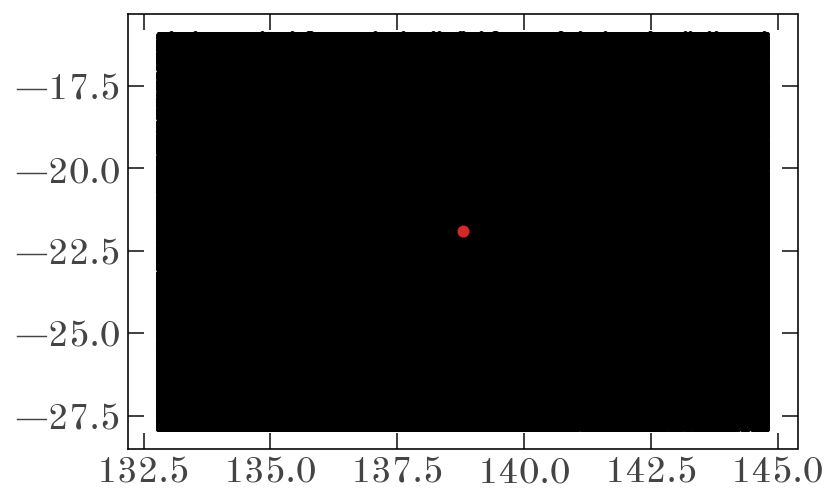

In [7]:
plt.plot(besancon['RAJ2000'], besancon['DECJ2000'], 
         marker='.', ls='none')
plt.scatter(field_icrs.ra.degree, field_icrs.dec.degree, 
            color='tab:red', zorder=100)

In [8]:
bes_ugr = np.stack((besancon['u'], besancon['g'], besancon['r'])).T

In [9]:
bes_c_icrs = coord.SkyCoord(besancon['RAJ2000'], 
                            besancon['DECJ2000'],
                            unit=u.deg)
bes_c = bes_c_icrs.transform_to(stream_frame)
bes_coo = np.stack((bes_c.phi1.degree,
                    bes_c.phi2.degree)).T

# bes_coo = np.stack((besancon['RAJ2000'], 
#                     besancon['DECJ2000'])).T

## Simulate stream stellar pop:

Parameters in Table 1 of Jetwa paper

In [10]:
age = 12.1 * u.Gyr
feh = -1.7
total_stellar_mass = 25e3 * u.Msun
width = 0.18 * u.deg
distance = 28.6 * u.kpc
distmod = coord.Distance(distance).distmod.value

In [11]:
np.log10(age.to_value(u.yr))

10.08278537031645

In [12]:
all_iso = at.Table.read(f'/Users/apricewhelan/data/Isochrones/mist/mist_v1.2_vvcrit0.0.fits')

/Users/apricewhelan/projects/astropy-all/astropy/astropy/io/fits/column.py:831: VerifyWarning: It is strongly recommended that column names contain only upper and lower-case ASCII letters, digits, or underscores for maximum compatibility with other software (got '[Fe/H]_init').
  warnings.warn(

/Users/apricewhelan/projects/astropy-all/astropy/astropy/io/fits/column.py:831: VerifyWarning: It is strongly recommended that column names contain only upper and lower-case ASCII letters, digits, or underscores for maximum compatibility with other software (got '[Fe/H]').
  warnings.warn(



In [13]:
iso_mask = (
    np.isclose(all_iso['log10_isochrone_age_yr'], 10.1) &
    np.isclose(all_iso['[Fe/H]_init'], -1.75)
)
iso = all_iso[iso_mask]

In [14]:
cluster = imf.make_cluster(total_stellar_mass.value, 
                           massfunc='kroupa')
rng.shuffle(cluster)

jet_ugr = np.zeros((len(cluster), 3))
for i, f in enumerate('ugr'):
    interp = interp1d(iso['initial_mass'], iso[f'DECam_{f}'], kind='cubic', 
                      bounds_error=False)
    jet_ugr[:, i] = interp(cluster) + distmod

Total cluster mass is 25000 (limit was 25000)


In [15]:
np.isnan(jet_ugr[:, 0]).sum()

26275

In [16]:
# Linear stream density:
lsd = total_stellar_mass / (11.5*u.deg)

njet = len(jet_ugr)
jet_coo_phi12 = np.zeros((len(jet_ugr), 2))

# jet_coo_phi12[:, 0] = np.random.uniform(-6, 5.5, size=njet)
jet_coo_phi12[:njet // 2, 0] = rng.uniform(-6, -0.5, size=njet // 2)
jet_coo_phi12[njet // 2:, 0] = rng.uniform(0.5, 5.5, size=njet - njet // 2)

jet_coo_phi12[:, 1] = rng.normal(0, width.to_value(u.deg), size=njet)

_bins = np.linspace(-6, 5.5, 32)
H, xe = np.histogram(jet_coo_phi12[:, 0], bins=_bins)
H / (xe[1:] - xe[:-1]) * u.count / u.deg

<Quantity [5208.        , 5202.60869565, 5288.86956522, 5164.86956522,
           5154.08695652, 5270.        , 5369.73913043, 5108.26086957,
           5267.30434783, 5307.73913043, 5243.04347826, 5305.04347826,
           5043.56521739, 5288.86956522, 4234.86956522,    0.        ,
              0.        , 2792.69565217, 5744.43478261, 5550.34782609,
           5787.56521739, 5722.86956522, 5620.43478261, 5720.17391304,
           5952.        , 5900.7826087 , 5822.60869565, 5725.56521739,
           5547.65217391, 5709.39130435, 5860.34782609] ct / deg>

In [17]:
lsd

<Quantity 2173.91304348 solMass / deg>

In [18]:
rng.choice(cluster, size=5000).sum()

2208.6569707892395

OK this is consistent!

In [19]:
# tmp = coord.SkyCoord(jet_coo_phi12[:, 0]*u.deg, 
#                      jet_coo_phi12[:, 1]*u.deg,
#                      frame=stream_frame).transform_to('icrs')
# jet_coo = np.stack((tmp.ra.degree,
#                     tmp.dec.degree)).T
jet_coo = jet_coo_phi12

Reddening:

In [20]:
jet_c_icrs = coord.SkyCoord(
    jet_coo_phi12[:, 0]*u.deg, 
    jet_coo_phi12[:, 1]*u.deg,
    frame=stream_frame).transform_to('icrs')

In [21]:
sfd = SFDQuery()
jet_ebv = sfd.query(jet_c_icrs)
bes_ebv = sfd.query(bes_c_icrs)

In [22]:
coeffs = {
    'u': 4.2,  # NOTE: adopted LSST u value
    'g': 3.172,
    'r': 2.271, 
    'i': 1.682, 
    'z': 1.322, 
    'y': 1.087
}

In [23]:
bes_Avals = {k: coeffs[k] * bes_ebv for k in coeffs}
jet_Avals = {k: coeffs[k] * jet_ebv for k in coeffs}

## Simulated photometry:

Function to compute SNR/errors -- see crazy DECam error scaling section way down at bottom if you really want to see...

In [24]:
def mag_to_flux(mag, ref_mag=26):
    return 10 ** (-mag / ref_mag)
    
def flux_to_flux_err(flux, snr_ref_mag=None, snr_at_ref_mag=5):
    coeffs = np.array([
        -3581.695821355337,
        4645.825598226179,
        -2155.5244653558734,
        426.4130850321785,
        -25.070367404097226])
    poly = np.poly1d(coeffs)
    
    scale = 1.
    if snr_ref_mag is not None:
        scale = mag_to_flux(snr_ref_mag) / mag_to_flux(24.72)
    
    flux_snr = np.exp(poly(flux / scale))
    return flux / flux_snr


def mag_to_mag_err(mag, snr_ref_mag=None, snr_at_ref_mag=5):
    flux = mag_to_flux(mag)
    flux_err = flux_to_flux_err(flux, snr_ref_mag, snr_at_ref_mag)
    flux_snr = flux / flux_err
    return 1 / flux_snr

In [55]:
ugr_lims = [26, 23.5, 23.5]
# ugr_lims = [30, 30, 30]

In [56]:
jet_ugr_err = np.zeros_like(jet_ugr)
jet_ugr_obs = np.zeros_like(jet_ugr)
for i, k in enumerate('ugr'):
    mag = jet_ugr[:, i] + jet_Avals[k]
    jet_ugr_err[:, i] = mag_to_mag_err(mag, snr_ref_mag=ugr_lims[i])
    jet_ugr_obs[:, i] = rng.normal(mag, jet_ugr_err[:, i])
    jet_ugr_obs[:, i][jet_ugr[:, i] > (ugr_lims[i]+0.5)] = np.nan
    jet_ugr_obs[:, i][(jet_ugr_obs[:, i] / jet_ugr_err[:, i]) < 8] = np.nan
    jet_ugr_obs[:, i] -= jet_Avals[k]

In [57]:
bes_ugr_err = np.zeros_like(bes_ugr)
bes_ugr_obs = np.zeros_like(bes_ugr)
for i, k in enumerate('ugr'):
    mag = bes_ugr[:, i] + bes_Avals[k]
    bes_ugr_err[:, i] = mag_to_mag_err(mag, snr_ref_mag=ugr_lims[i])
    bes_ugr_obs[:, i] = rng.normal(mag, bes_ugr_err[:, i])
    bes_ugr_obs[:, i][bes_ugr[:, i] > (ugr_lims[i]+0.5)] = np.nan
    bes_ugr_obs[:, i][(bes_ugr_obs[:, i] / bes_ugr_err[:, i]) < 8] = np.nan
    bes_ugr_obs[:, i] -= bes_Avals[k]

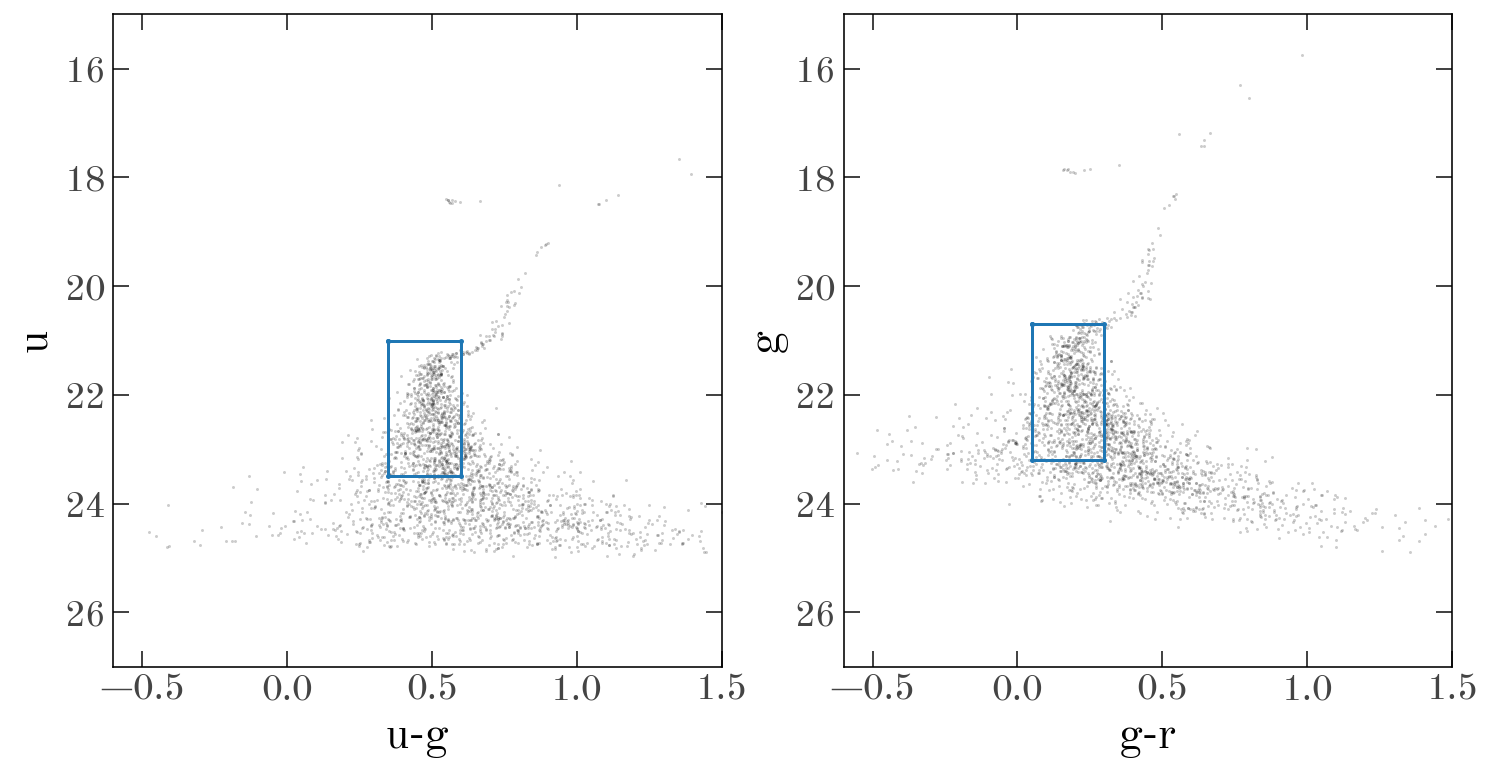

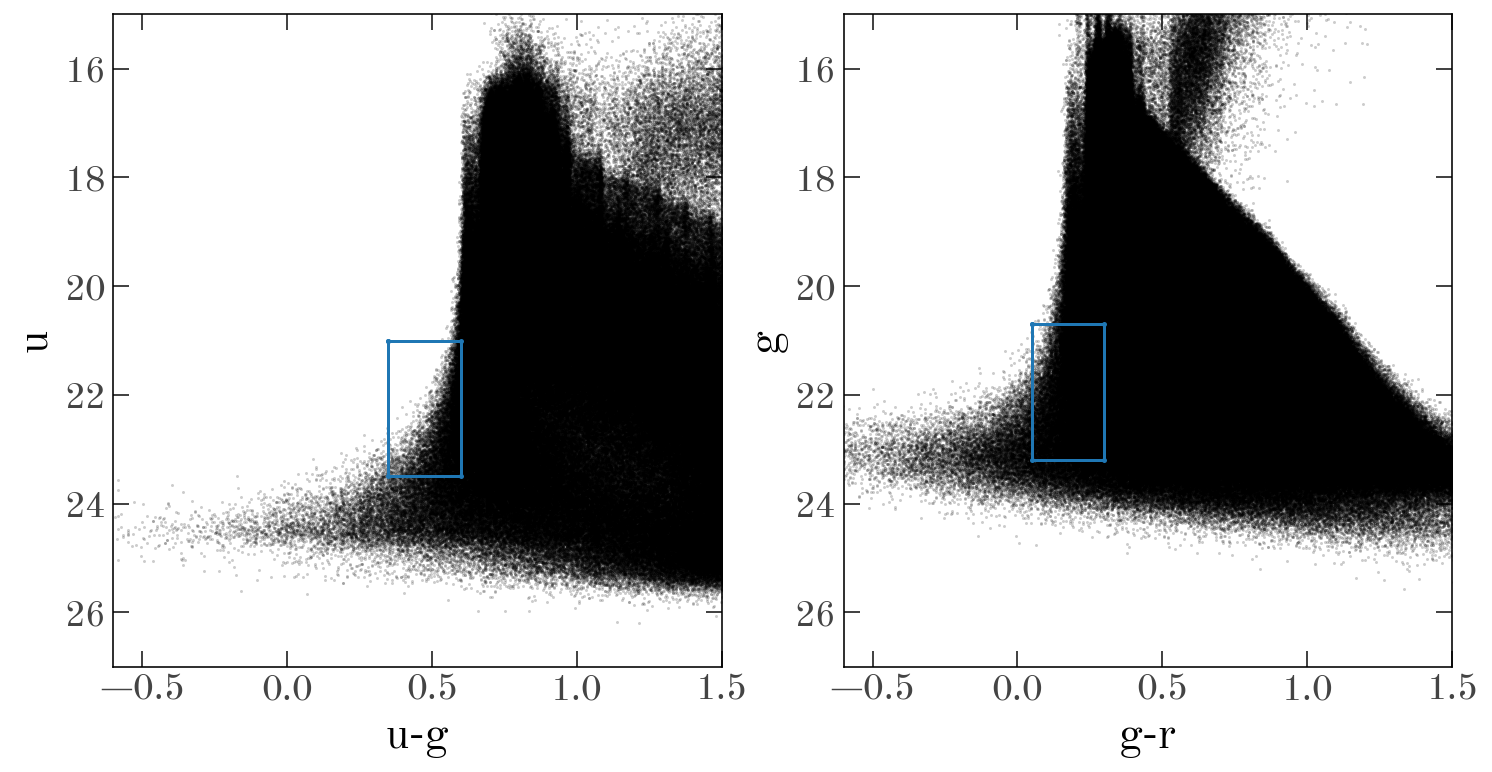

In [58]:
ugu_poly_nodes = np.array([
    [0.35, 21.],
    [0.35, 23.5],
    [0.6, 23.5],
    [0.6, 21.],
    [0.35, 21.]
])
ugu_poly = mpl.path.Path(ugu_poly_nodes)

grg_poly_nodes = np.array([
    [0.05, 20.7],
    [0.05, 23.2],
    [0.3, 23.2],
    [0.3, 20.7],
    [0.05, 20.7]
])
grg_poly = mpl.path.Path(grg_poly_nodes)

for ugr in [jet_ugr_obs, bes_ugr_obs]:
# for ugr in [jet_ugr, bes_ugr]:
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    ax = axes[0]
    ax.plot(ugr[:, 0] - ugr[:, 1], ugr[:, 0],
            marker='o', ls='none', ms=1.5, alpha=0.2)
    ax.set(
        xlim=(-0.6, 1.5),
        ylim=(27, 15),
        xlabel='u-g',
        ylabel='u'
    );
    
    ax.plot(ugu_poly_nodes[:, 0], ugu_poly_nodes[:, 1])

    ax = axes[1]
    ax.plot(ugr[:, 1] - ugr[:, 2], ugr[:, 1],
            marker='o', ls='none', ms=1.5, alpha=0.2)
    ax.set(
        xlim=(-0.6, 1.5),
        ylim=(27, 15),
        xlabel='g-r',
        ylabel='g'
    );
    ax.plot(grg_poly_nodes[:, 0], grg_poly_nodes[:, 1])

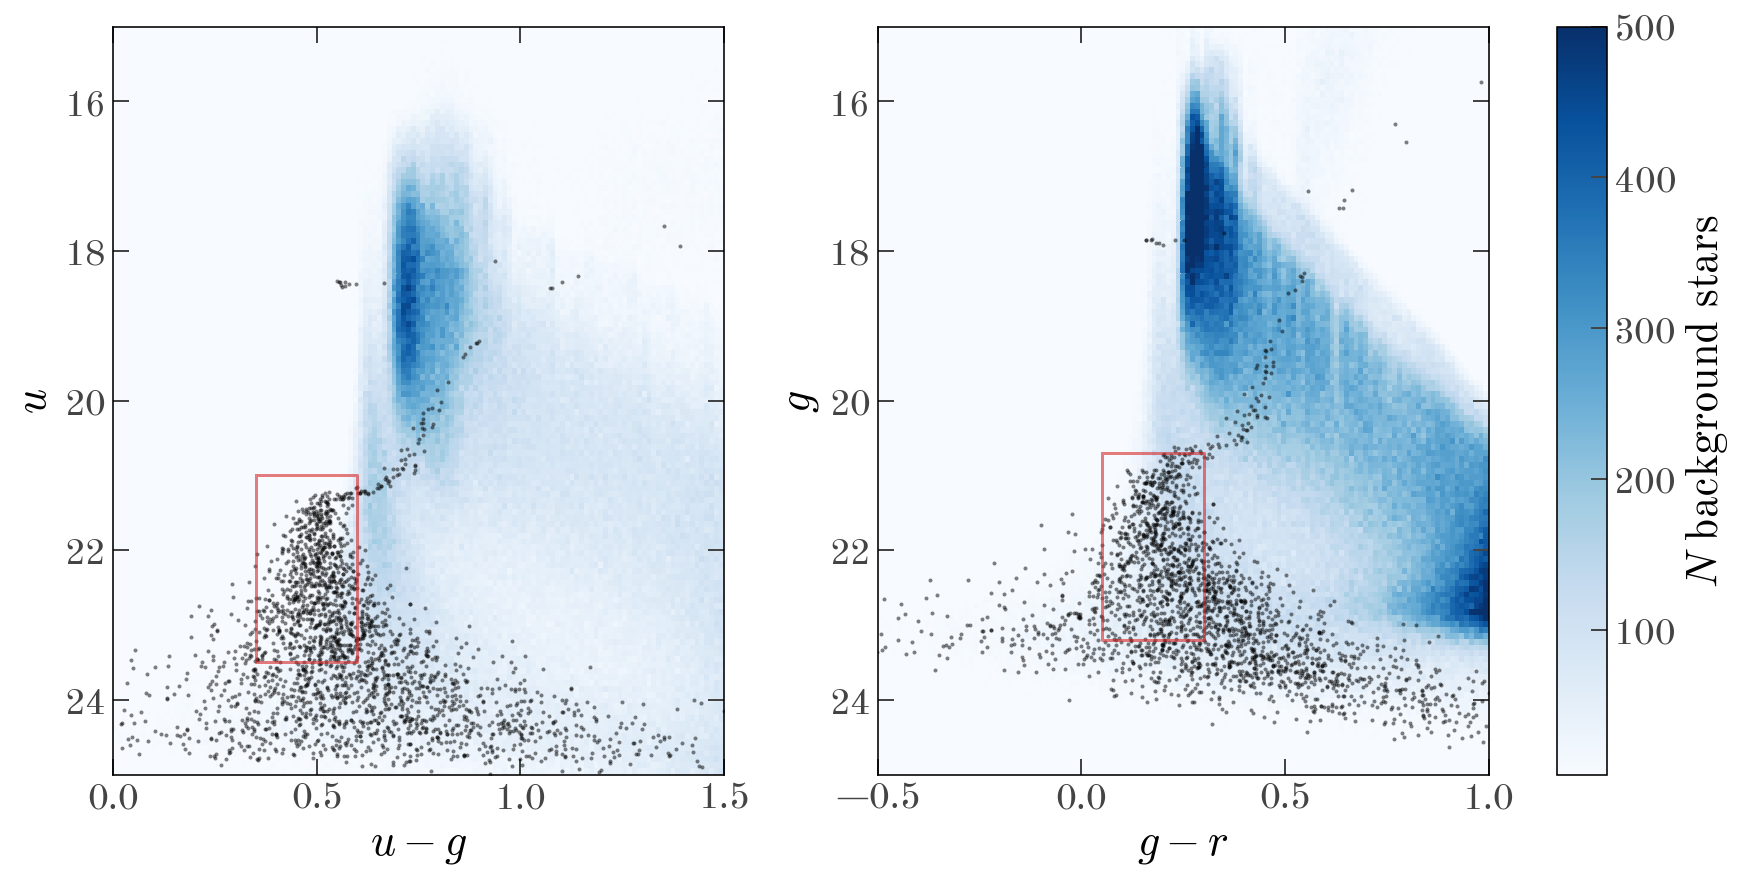

In [59]:
ugu_bins = (np.linspace(0, 1.5, 128),
            np.linspace(15, 25, 128))
grg_bins = (np.linspace(-0.5, 1.0, 128),
            np.linspace(15, 25, 128))

hist2d_style = dict(zorder=-100, cmap='Blues',
                    vmin=4, vmax=5e2)
#                     norm=mpl.colors.LogNorm(vmin=4, vmax=5e2))

stream_style = dict(marker='o', ls='none', ms=2., alpha=0.5)

fig, axes = plt.subplots(1, 2, figsize=(12, 6), 
                         constrained_layout=True)

ax = axes[0]
ax.plot(jet_ugr_obs[:, 0] - jet_ugr_obs[:, 1], jet_ugr_obs[:, 0],
        **stream_style)
*_, im = ax.hist2d(
    bes_ugr_obs[:, 0] - bes_ugr_obs[:, 1], bes_ugr_obs[:, 0],
    bins=ugu_bins, 
    **hist2d_style)
ax.set(
    xlim=(ugu_bins[0].min(), ugu_bins[0].max()),
    ylim=(ugu_bins[1].max(), ugu_bins[1].min()),
    xlabel='$u-g$',
    ylabel='$u$'
);

ax.plot(ugu_poly_nodes[:, 0], 
        ugu_poly_nodes[:, 1],
        color='tab:red', marker='', alpha=0.6)

# ----
ax = axes[1]
ax.plot(jet_ugr_obs[:, 1] - jet_ugr_obs[:, 2], jet_ugr_obs[:, 1],
        **stream_style)
ax.hist2d(
    bes_ugr_obs[:, 1] - bes_ugr_obs[:, 2], bes_ugr_obs[:, 1],
    bins=grg_bins, 
    **hist2d_style)

ax.set(
    xlim=(grg_bins[0].min(), grg_bins[0].max()),
    ylim=(grg_bins[1].max(), grg_bins[1].min()),
    xlabel='$g-r$',
    ylabel='$g$'
);

ax.plot(grg_poly_nodes[:, 0], 
        grg_poly_nodes[:, 1], 
        color='tab:red', marker='', alpha=0.6)

cb = fig.colorbar(im, ax=axes, aspect=30)
cb.set_label('$N$ background stars')

In [60]:
data = {
    'Jet': {
        'ugr': jet_ugr_obs,
        'style': dict(color='tab:red'),
        'c': jet_coo
    },
    'background': {
        'ugr': bes_ugr_obs,
        'style': dict(color='#666666'),
        'c': bes_coo
    }
}

default_style = dict(marker='o', ls='none', ms=1.5, alpha=0.2)
for k in data:
    data[k]['style'].update(default_style)

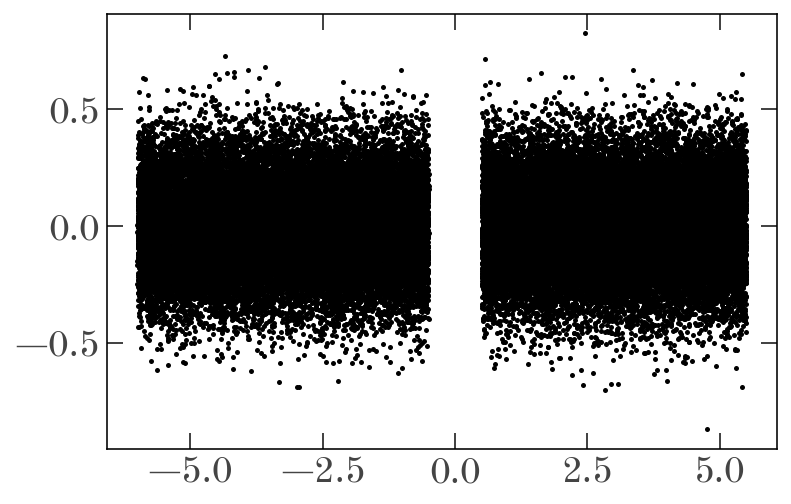

In [61]:
plt.plot(data['Jet']['c'][:, 0],
         data['Jet']['c'][:, 1],
         ls='none')

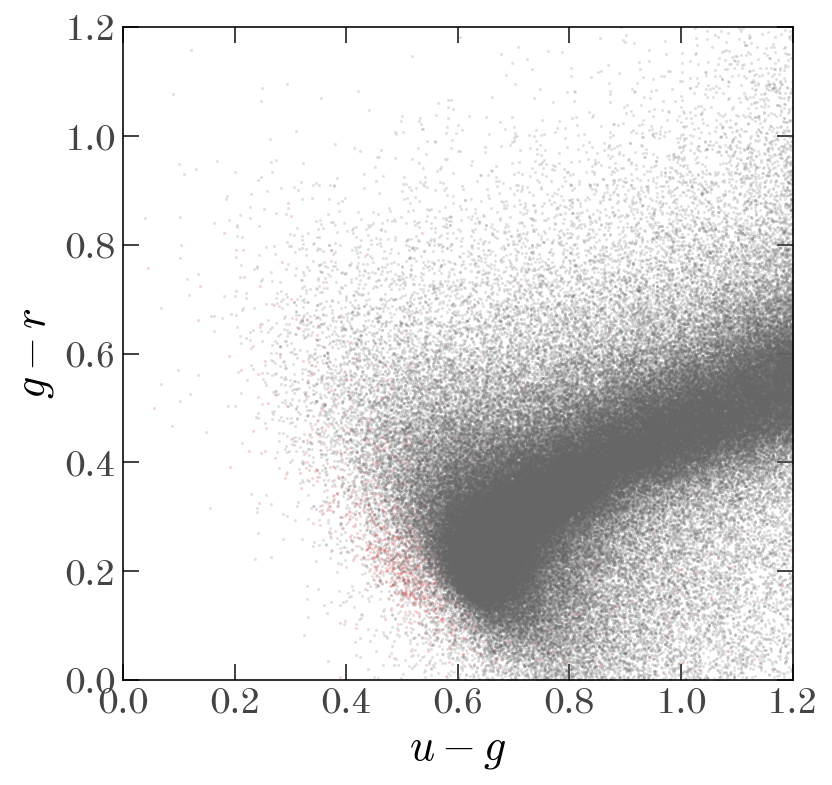

In [62]:
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

for k, d in data.items():
    _mask = (
        (d['ugr'][:, 0] < 25.) & 
        (d['ugr'][:, 1] < 23.5) & (d['ugr'][:, 1] > 20) &
        (d['ugr'][:, 2] < 23.5)
    )
    ax.plot((d['ugr'][:, 0] - d['ugr'][:, 1])[_mask], 
            (d['ugr'][:, 1] - d['ugr'][:, 2])[_mask],
            **d['style'])

ax.set(
    xlim=(0, 1.2),
    ylim=(0, 1.2),
    xlabel='$u-g$',
    ylabel='$g-r$'
);

## Simulate CMD selection

In [63]:
masks = {}
for k, d in data.items():
    masks[k] = {}
    
    X = np.stack((d['ugr'][:, 0] - d['ugr'][:, 1],
                  d['ugr'][:, 0])).T
    masks[k]['ugu'] = ugu_poly.contains_points(X)
    
    X = np.stack((d['ugr'][:, 1] - d['ugr'][:, 2],
                  d['ugr'][:, 1])).T
    masks[k]['grg'] = grg_poly.contains_points(X)

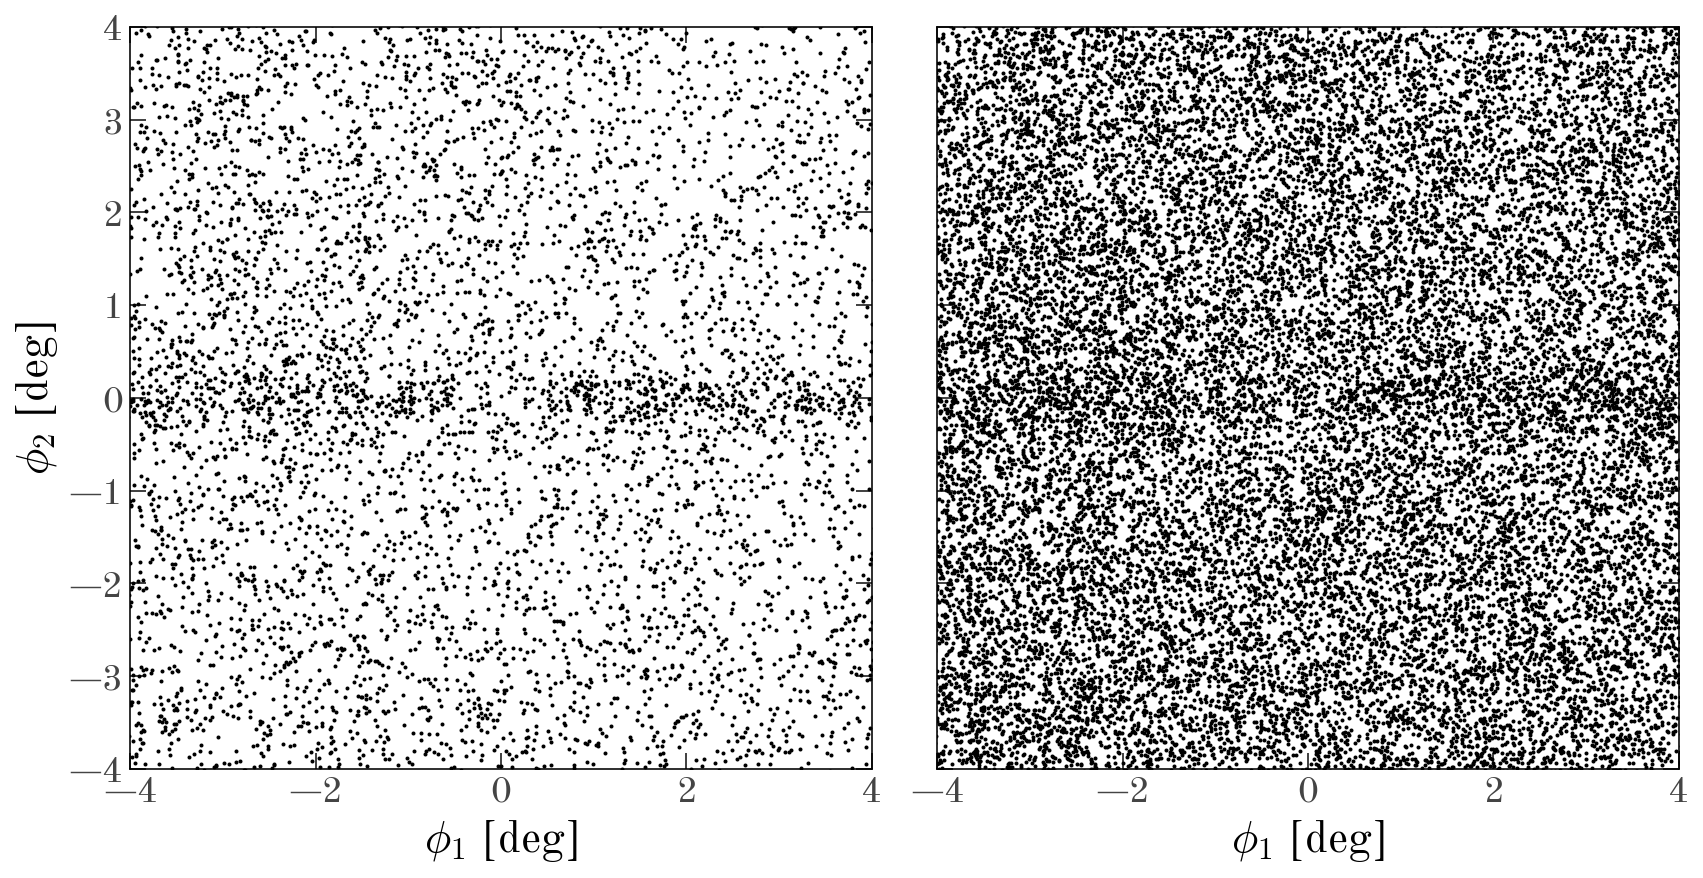

In [64]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6), 
                         sharex=True, sharey=True)

for i, k in enumerate(['ugu', 'grg']):
    ax = axes[i] 
    
    skystyle = dict(color='k', alpha=1, ms=4., ls='none')

    d = data['background']
    mask = masks['background'][k]
    ax.plot(*d['c'][mask].T, **skystyle)

    d = data['Jet']
    mask = masks['Jet'][k]
    ax.plot(*d['c'][mask].T, **skystyle)

    ax.set_xlabel(r'$\phi_1$ [deg]')
    if i == 0:
        ax.set_ylabel(r'$\phi_2$ [deg]')
    ax.set_aspect('equal')

ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)

fig.tight_layout()

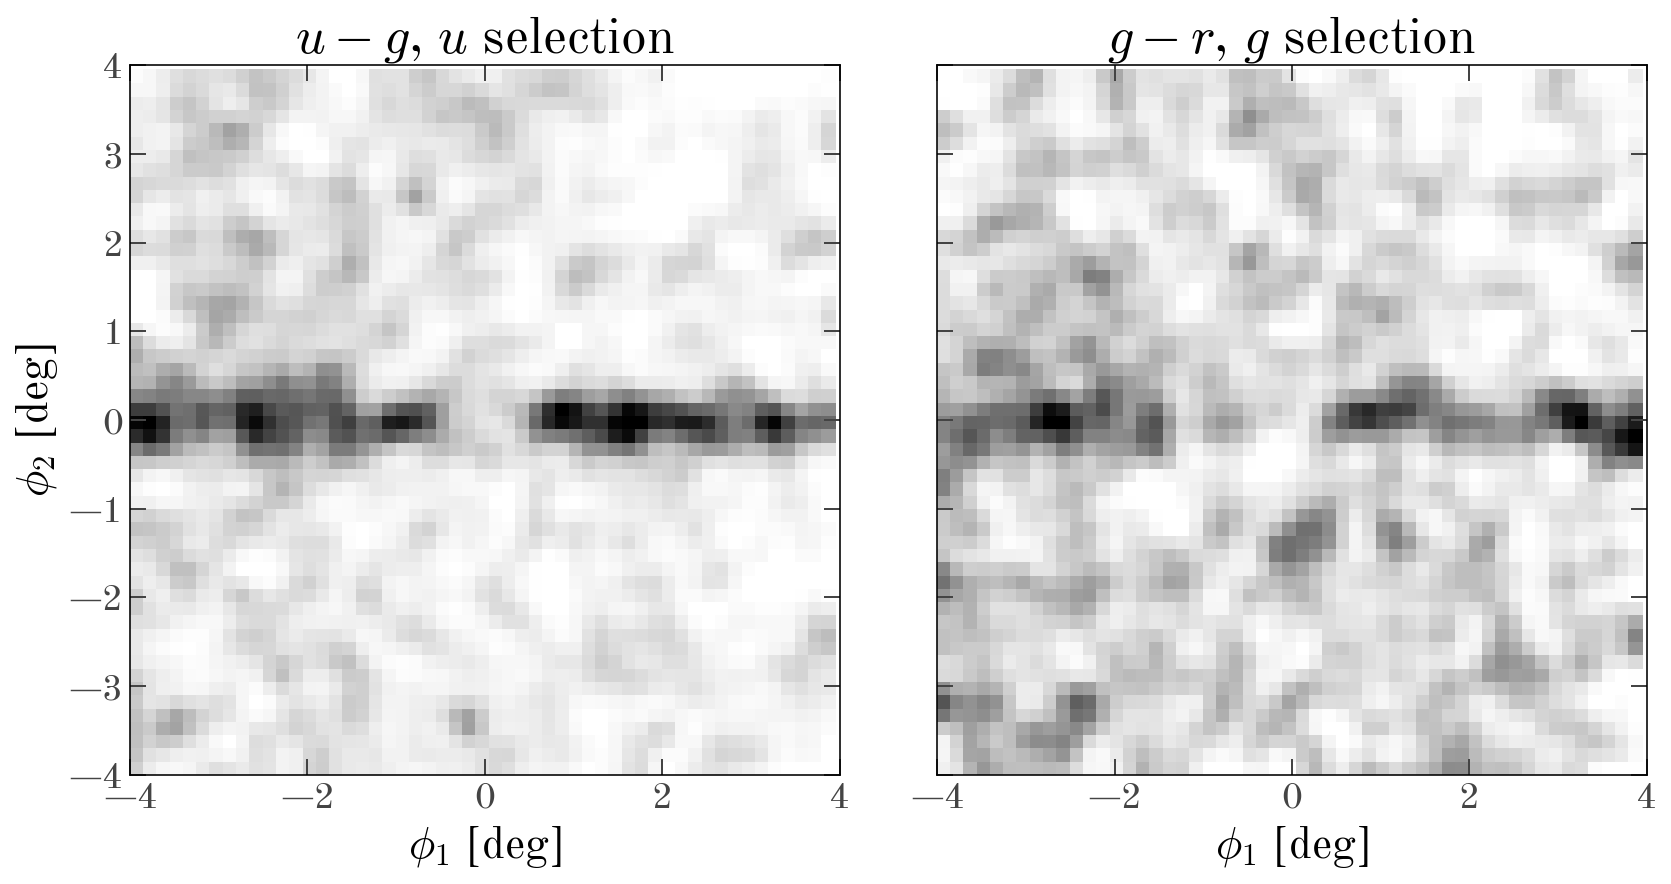

In [65]:
from scipy.ndimage import gaussian_filter

bins = np.arange(-4, 4+1e-3, 0.15)

fig, axes = plt.subplots(1, 2, figsize=(12, 6), 
                         sharex=True, sharey=True)

for i, k in enumerate(['ugu', 'grg']):
    ax = axes[i] 

    skystyle = dict(color='k', alpha=1, ms=4., ls='none')

    d = data['background']
    mask = masks['background'][k]
    c1 = d['c'][mask].T
    
    d = data['Jet']
    mask = masks['Jet'][k]
    c2 = d['c'][mask].T
    
    all_c = np.hstack((c1, c2))
    
    H, xe, ye = np.histogram2d(*all_c, bins=bins)
    HH = gaussian_filter(H, 1).T
    # HH = H.T
    ax.pcolormesh(xe, ye, HH, 
                  cmap='Greys', 
                  vmin=np.percentile(HH, 5), 
                  vmax=np.percentile(HH, 99.9))

    ax.set_xlabel(r'$\phi_1$ [deg]')
    if i == 0:
        ax.set_ylabel(r'$\phi_2$ [deg]')
    ax.set_aspect('equal')

axes[0].set_title('$u-g$, $u$ selection')
axes[1].set_title('$g-r$, $g$ selection')
    
ax.set_xlim(-4, 4)
ax.set_ylim(-4, 4)

fig.tight_layout()

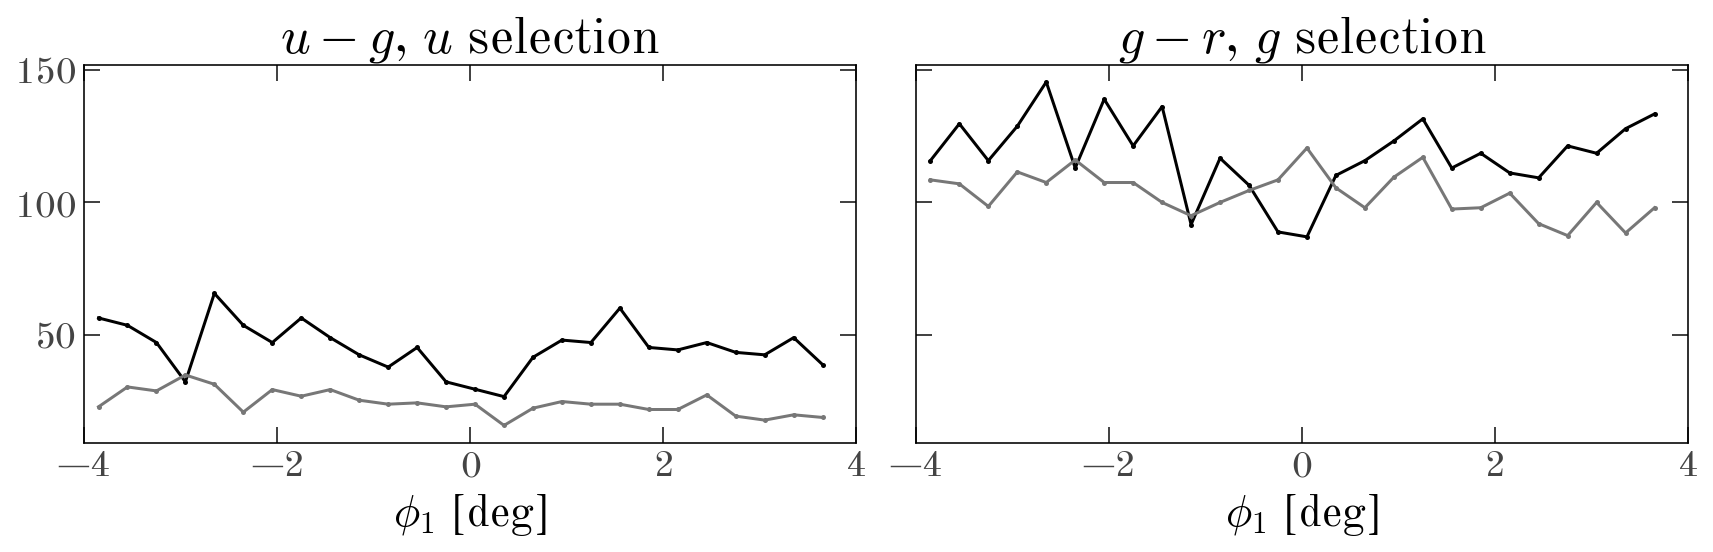

In [66]:
bins = np.arange(-4, 4+1e-3, 0.3)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), 
                         sharex=True, sharey=True)

for i, k in enumerate(['ugu', 'grg']):
    ax = axes[i] 

    d = data['background']
    mask = masks['background'][k]
    c1 = d['c'][mask].T
    
    d = data['Jet']
    mask = masks['Jet'][k]
    c2 = d['c'][mask].T
    
    all_c = np.hstack((c1, c2))
    
    bg_mask = (
        ((all_c[1] > 1) & (all_c[1] < 2)) |
        ((all_c[1] > -2) & (all_c[1] < -1))
    )
    bg_H, xe = np.histogram(all_c[0, bg_mask], bins=bins)
    bg_dens = bg_H / 2
    
    fg_size = 3 * width.to_value(u.deg)
    fg_mask = (np.abs(all_c[1]) < fg_size)
    fg_H, xe = np.histogram(all_c[0, fg_mask], bins=bins)
    fg_dens = fg_H / (fg_size * 2)
    
    xctr = 0.5 * (xe[:-1] + xe[1:])
    ax.plot(xctr, fg_dens)
    ax.plot(xctr, bg_dens, color='#777777')

    ax.set_xlabel(r'$\phi_1$ [deg]')

axes[0].set_title('$u-g$, $u$ selection')
axes[1].set_title('$g-r$, $g$ selection')
    
ax.set_xlim(-4, 4)
# ax.set_ylim(-4, 4)

fig.tight_layout()

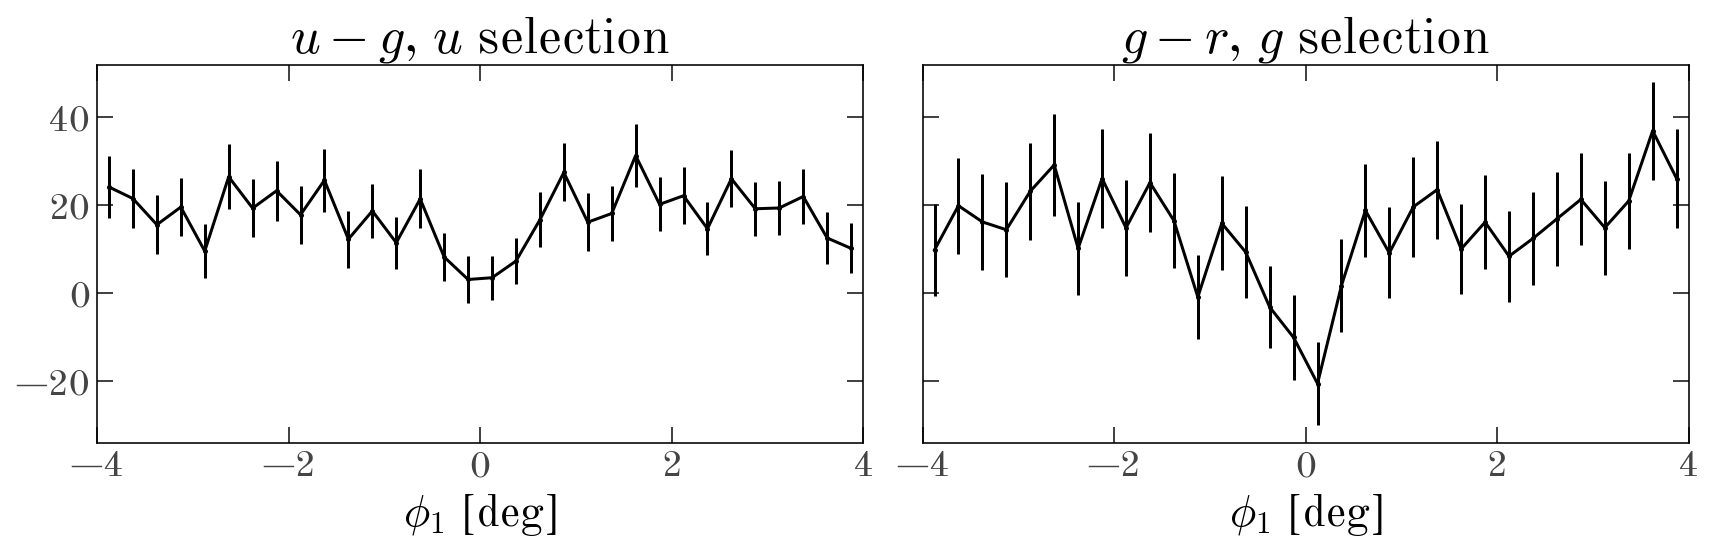

In [67]:
bins = np.arange(-4, 4+1e-3, 0.25)

fig, axes = plt.subplots(1, 2, figsize=(12, 4), 
                         sharex=True, sharey=True)

for i, k in enumerate(['ugu', 'grg']):
    ax = axes[i] 

    d = data['background']
    mask = masks['background'][k]
    c1 = d['c'][mask].T
    
    d = data['Jet']
    mask = masks['Jet'][k]
    c2 = d['c'][mask].T
    
    all_c = np.hstack((c1, c2))
    
    bg_mask = (
        ((all_c[1] > 1) & (all_c[1] < 3)) |
        ((all_c[1] > -3) & (all_c[1] < -1))
    )
    bg_H, xe = np.histogram(all_c[0, bg_mask], bins=bins)
    bg_dens = bg_H / 4
    bg_err = np.sqrt(bg_H) / 4
    
    fg_size = 3 * width.to_value(u.deg)
    fg_mask = (np.abs(all_c[1]) < fg_size)
    fg_H, xe = np.histogram(all_c[0, fg_mask], bins=bins)
    fg_dens = fg_H / (fg_size * 2)
    fg_err = np.sqrt(fg_H) / (fg_size * 2)
    
    xctr = 0.5 * (xe[:-1] + xe[1:])
    ax.errorbar(xctr, fg_dens - bg_dens, 
                np.sqrt(fg_err**2 + bg_err**2))

    ax.set_xlabel(r'$\phi_1$ [deg]')

axes[0].set_title('$u-g$, $u$ selection')
axes[1].set_title('$g-r$, $g$ selection')
    
ax.set_xlim(-4, 4)
# ax.set_ylim(-4, 4)

fig.tight_layout()

## Crazy DECam error scaling stuff:

In [ ]:
def get_snr_poly(mag_lim, snr_at_mag_lim=5):
    coeff_mag_lim = 23.5
    coeffs = np.array([1.83211666e-04,  2.80269861e-03, -5.69101165e-02, -8.14196667e-01, 5.89345428e+00])
    coeffs[-1] -= np.poly1d(coeffs)(mag_lim - coeff_mag_lim) - np.log(snr_at_mag_lim)
    return lambda x: np.exp(np.poly1d(coeffs)(x - coeff_mag_lim))

In [ ]:
derp = at.Table.read('/Users/apricewhelan/projects/dr2-lmc-cluster/data/decam_apw.fits')

In [ ]:
derp_mask = (
    (derp['GMAG'] > 15) &
    (derp['GMAG'] < 28) &
    (derp['GERR'] > 1e-3) &
    (derp['GERR'] < 1e1)
)
derp = derp[derp_mask]

In [ ]:
ref_mag = 26.
flux = 10 ** (-derp['GMAG'] / ref_mag)
flux_snr = 1 / derp['GERR']

flux = np.append(flux, [0.5])
flux_snr = np.append(flux_snr, [500])

flux_err = flux / flux_snr

In [ ]:
plt.plot(flux, np.log(flux_err), ls='none')

In [ ]:
plt.plot(flux, flux_snr,
         marker='o', mew=0, ls='none', ms=1,
         alpha=0.2)

grid = np.linspace(flux.min(), flux.max(), 128) 
coeffs = np.polyfit(flux, np.log(flux_snr), deg=4)
poly = np.poly1d(coeffs)
plt.plot(grid, np.exp(poly(grid)))

# plt.xscale('log')
plt.yscale('log')
# plt.xlim(15, 28)

In [ ]:
coeffs.tolist()

In [ ]:
def mag_to_flux(mag, ref_mag=26):
    return 10 ** (-mag / ref_mag)
    
def flux_to_flux_err(flux, snr_ref_mag=None, snr_at_ref_mag=5):
    coeffs = np.array([
        -3581.695821355337,
        4645.825598226179,
        -2155.5244653558734,
        426.4130850321785,
        -25.070367404097226])
    poly = np.poly1d(coeffs)
    
    scale = 1.
    if snr_ref_mag is not None:
        scale = mag_to_flux(snr_ref_mag) / mag_to_flux(24.72)
    
    flux_snr = np.exp(poly(flux / scale))
    return flux / flux_snr


def mag_to_mag_err(mag, snr_ref_mag=None, snr_at_ref_mag=5):
    flux = mag_to_flux(mag)
    flux_err = flux_to_flux_err(flux, snr_ref_mag, snr_at_ref_mag)
    flux_snr = flux / flux_err
    return 1 / flux_snr

In [ ]:
mag0 = 22.
mag_to_flux(mag0) / flux_to_flux_err(mag_to_flux(mag0), snr_ref_mag=mag0)

In [ ]:
plt.figure(figsize=(6, 6))
plt.plot(
    derp['GERR'],
    (derp['GERR'] - mag_to_mag_err(derp['GMAG'])) / derp['GERR'],
    ls='none', ms=1
)
plt.xscale('log')